## Introduction

Our purpose there is to create a good movie recommender for Netflix users, using the Netflix prize dataset. To do so, we'll try to forecast the star ratings that a Netflix user would give to one movie using Model-Based Machine Learning.

## Imports

In [1]:
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import random
import pystan
from sklearn.model_selection import train_test_split
import pandas as pd
#import pystan_utils
# matplotlib options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

In [2]:
# usually have to run this twice to take effect
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

# Data Exploration

In [3]:
# Load dataset (Here we only the first third of the data, there are two more files, but for the preparation purposes
# we are loading only one. This speeds things up considerably.)

df3 = pd.read_csv('combined_data_3.txt', header = None, names = ['User_Id', 'Rating','Date'], usecols = [0,1,2])
df = df3

####  Quick visualisation of the data.
Data is currently structured as follows:
ID of movie followed by user ratings of this movie. 
In these first five lines we see 4 ratings, respectively 1, 2, 3 and 1 out of 5 stars for the movie with ID=9211.
We will transform this structure so that instead of having the movie ID as a line, we have it as an additional column

In [4]:
df3.head() # 

,User_Id,Rating,Date
0,9211:,NaN,NaN
1,1277134,1.0,2003-12-02
2,2435457,2.0,2005-06-01
3,2338545,3.0,2001-02-17
4,2218269,1.0,2002-12-27


### Clean Data and Transform Movie Id's from row value to column

Below, all the movies having received no ratings are removed from the dataset. Furthermore, we transform the Movie ID's from rows to columns.

In [5]:
# Remove rows were there is no rating
df_nan = pd.DataFrame(pd.isnull(df.Rating))
df_nan = df_nan[df_nan['Rating'] == True]
df_nan = df_nan.reset_index()

movie_np = []
movie_id = 1

for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
    temp = np.full((1,i-j-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1

# Account for last record and corresponding length

last_record = np.full((1,len(df) - df_nan.iloc[-1, 0] - 1),movie_id)
movie_np = np.append(movie_np, last_record)

# remove those Movie ID rows
df = df[pd.notnull(df['Rating'])]

df.loc[:,'Movie_Id'] = movie_np.astype(int)
df.loc[:,'User_Id'] = df['User_Id'].astype(int)
df.loc[:,'Date'] = pd.to_datetime(df['Date'])
df.head()

/home/cernewein/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/cernewein/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,User_Id,Rating,Date,Movie_Id
1,1277134,1.0,2003-12-02,1
2,2435457,2.0,2005-06-01,1
3,2338545,3.0,2001-02-17,1
4,2218269,1.0,2002-12-27,1
5,441153,4.0,2002-10-11,1


In [6]:
df.loc[:,'Movie_Id'] = df.loc[:,'Movie_Id'] + 9210
df.to_csv('data3.csv') # Saving transformed data in order so that we don't recompute everything all the time

### Statistics

Below are the number of unique movies and the number of unique users. For our purposes it is good to have as many ratings per movie and ratings per user as possible

In [7]:
print(len(df['Movie_Id'].unique())) # Number of movies
len(df['User_Id'].unique()) # Number of users

4157


474662

Next we are looking at the number of ratings per movie, as can be seen in the next cell, there are huge differences between the number of ratings from one movie to another. This difference can be as big as 3 orders of magnitude. The ratings aren't well distributed amongst the movies, this might have an impact on our model.

In [8]:
df.groupby('Movie_Id').count()['Rating']

Movie_Id
9211        504
9212        841
9213        143
9214        364
9215        375
9216        327
9217       8808
9218       2369
9219        226
9220        323
9221        105
9222       2430
9223       1951
9224       9982
9225        289
9226        194
9227         88
9228       3895
9229      10663
9230        451
9231       3747
9232      14685
9233        931
9234      15704
9235      20214
9236      17307
9237       3165
9238       2485
9239        318
9240      12717
          ...  
13338       274
13339       263
13340       784
13341       297
13342     30546
13343       491
13344       138
13345       139
13346       556
13347       385
13348       115
13349       383
13350       404
13351       955
13352      1464
13353       175
13354       147
13355        95
13356       872
13357       567
13358       882
13359    113717
13360       188
13361       449
13362       322
13363       159
13364      1289
13365      1944
13366      1025
13367       101
Name: Rating, L

Below we compute the mean rating per movie. We again notice some big variations in between movies; the worst movie is rated under 1.5 on average while the best movie is rated over 4.5

In [9]:
mean_rating = df.groupby('Movie_Id').mean()['Rating']
print(mean_rating)
print(min(mean_rating))
print(max(mean_rating))

Movie_Id
9211     2.369048
9212     3.706302
9213     3.125874
9214     2.403846
9215     3.482667
9216     3.125382
9217     3.525545
9218     3.664837
9219     2.415929
9220     2.925697
9221     3.380952
9222     3.277778
9223     3.303434
9224     3.572430
9225     2.830450
9226     2.922680
9227     2.988636
9228     3.670347
9229     3.517584
9230     3.407982
9231     3.316520
9232     2.959551
9233     2.954887
9234     3.211156
9235     3.472989
9236     4.116196
9237     3.538073
9238     3.125553
9239     2.773585
9240     3.389007
           ...   
13338    2.481752
13339    2.885932
13340    2.330357
13341    2.986532
13342    3.224416
13343    3.152749
13344    3.311594
13345    2.410072
13346    3.685252
13347    2.768831
13348    2.556522
13349    3.691906
13350    3.153465
13351    3.589529
13352    3.007514
13353    3.154286
13354    1.496599
13355    3.610526
13356    3.000000
13357    3.753086
13358    2.407029
13359    3.594265
13360    3.180851
13361    2.817372
1

Number of ratings per user. Here we notice that some users have made over 200 ratings (one user apparently rated over 4000 movies !!), while others have only rated 1 movie. From these people that rated only one movie it will probably be harder to get any insights

In [10]:
user_ratings = df.groupby('User_Id').count()['Rating']
print(user_ratings)
print("Minimum number of ratings per user:", min(user_ratings))
print("Maximum number of ratings per user:", max(user_ratings))

User_Id
6          136
7          200
8           25
10          56
25           8
33           8
42          27
59          35
79         168
83           6
87          39
94          33
97         122
116         50
126          6
130         15
131         24
133          1
134        165
142         17
149          4
158         11
164         27
168          5
169         73
177         10
178          6
183         40
188        132
189          9
          ... 
2649267    196
2649268     10
2649285    224
2649288     51
2649296    175
2649299     57
2649308    138
2649311     48
2649323     29
2649326      5
2649328     74
2649331     61
2649335     78
2649336     72
2649337      5
2649343      1
2649351     24
2649370     60
2649375     43
2649376     28
2649378     76
2649379      2
2649384     13
2649388     64
2649401     27
2649404     17
2649409     12
2649421      7
2649426     59
2649429     55
Name: Rating, Length: 474662, dtype: int64
Minimum number of ratings per user

Below the mean of the ratings of each users is given. 

In [11]:
mean_rating_user = df.groupby('User_Id').mean()['Rating']
print(mean_rating_user)
print("Minimum mean rating per user:",min(mean_rating_user))
print("Maximum mean rating pr user:",max(mean_rating_user))

User_Id
6          3.500000
7          3.995000
8          4.200000
10         3.375000
25         3.500000
33         3.875000
42         4.111111
59         3.714286
79         3.404762
83         3.833333
87         3.512821
94         3.484848
97         3.245902
116        4.260000
126        5.000000
130        4.066667
131        3.416667
133        2.000000
134        4.624242
142        3.411765
149        4.500000
158        3.545455
164        4.296296
168        4.600000
169        3.808219
177        2.800000
178        2.666667
183        3.775000
188        3.454545
189        4.111111
             ...   
2649267    3.877551
2649268    3.700000
2649285    2.973214
2649288    3.960784
2649296    3.405714
2649299    4.649123
2649308    3.659420
2649311    4.187500
2649323    3.241379
2649326    2.600000
2649328    3.891892
2649331    3.737705
2649335    3.948718
2649336    3.486111
2649337    4.200000
2649343    3.000000
2649351    4.333333
2649370    3.716667
2649375    4

### Visualizations

Below are plotted the distributions of ratings per movie and of ratings per user. Both follow quite well an exponential distribution. We can see that very few movies/users have many ratings.

Text(0.5, 1.0, 'Distribution of Ratings Per User')

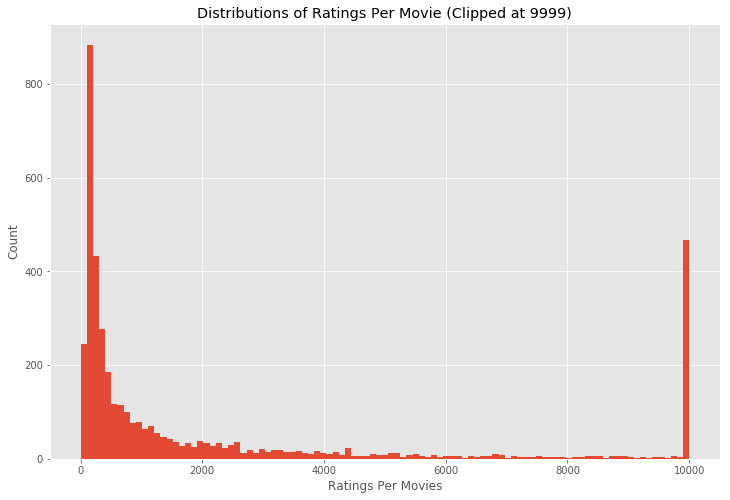

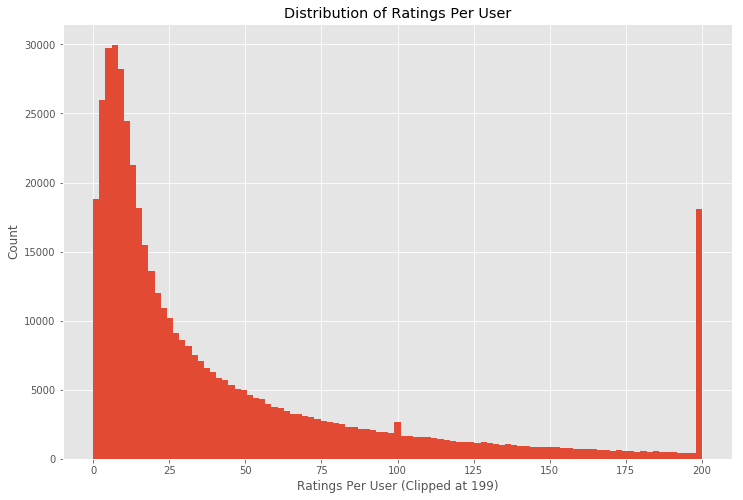

In [12]:
##### Ratings Per Movie #####
# Get data
data = df.groupby('Movie_Id')['Rating'].count().clip(upper=9999)

# Create trace
trace = plt.hist(x = data.values, bins = np.linspace(0,10000,100))
plt.xlabel("Ratings Per Movies")
plt.ylabel("Count")
plt.title("Distributions of Ratings Per Movie (Clipped at 9999)")
plt.figure()

##### Ratings Per User #####
# Get data
data = df.groupby('User_Id')['Rating'].count().clip(upper=199)
# Create trace
trace = plt.hist(x = data.values, bins = np.linspace(0,200,100))
plt.xlabel("Ratings Per User (Clipped at 199)")
plt.ylabel("Count")
plt.title("Distribution of Ratings Per User")

Here we take a look at the number of ratings per value of rating, ie the number of ratings 1, ratings 2 etc..
We notice that overall the rating of the movies seems to be neutral to positive.
This distribution is probably biased, since people liking the movies tends to stay customers, while some others presumably leave Netflix, at least when they didn't see a lot of movies they liked before seeing a movie they dislike.

Rating
1.0    0.047171
2.0    0.101030
3.0    0.284626
4.0    0.333942
5.0    0.233232
Name: User_Id, dtype: float64


<BarContainer object of 5 artists>

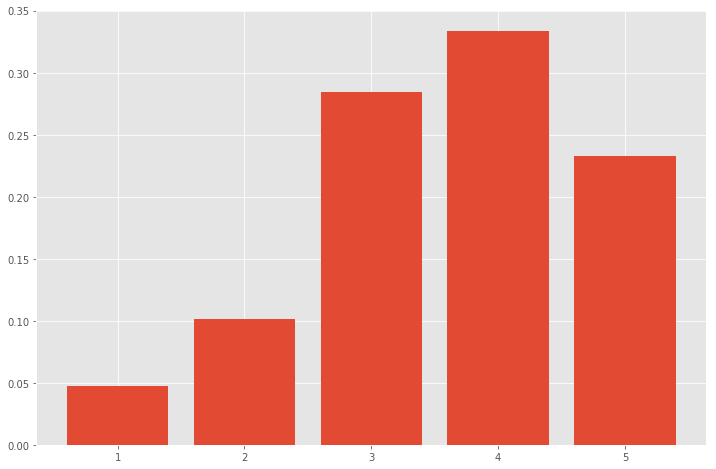

In [13]:
number_per_rating = df.groupby('Rating').count()['User_Id']
print(number_per_rating/len(df))
plt.bar(number_per_rating.index,number_per_rating.values/len(df))

### Auxiliary dataset: movie titles with years

We also have another dataset, being the movie Ids with associated title and the year the movie was released. The release year could be an interesting feature to add to our analysis

In [3]:
df_title = pd.read_csv('movie_titles.csv', encoding = "ISO-8859-1", header = None, names = ['Movie_Id', 'Year', 'Name'])
df_title.head()

,Movie_Id,Year,Name
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW


Below we can see when the movies were released. We can remark that most movies available on Netflix have been released recently. Yet, the decline of movies lately could maybe be explained by incomplete last year.

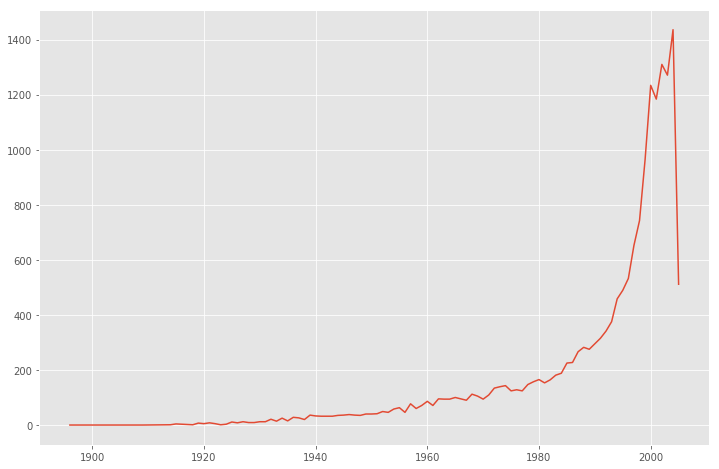

In [15]:
# Get data
data = df_title['Year'].value_counts().sort_index()

# Create trace

plt.plot(data.index,data.values)

##### In this section, we have been able to find some interesting insights such as the number of ratings per user, per movie, the average rating per user, per movie as well as the number of ratings per rating value.

##### In the next section, our goal will be to build a model for recommending the movies. More precisely, our model will have to estimate the rating a user would give to a movie he has not rated...

# Building of our model

In this section, we'll try to explain how we created the generative story and the PGM of our model.

First, we thought that the characteristics of a movie should be involved to forecast how many stars a user would give to a movie. Indeed, if a person A loves comedies but hates action or dramatic movies, he would surely give a better rating to a comedy than to an action movie. One should note however that we don't have measures or data that tells us directly whether one movie is rather a comedy, an action movie or something else. These characteristics of the movie, which we'll call traits, will then appear in our PGM and are values we'll have to infer. Furthermore, we'll also add the preference of a user for these different traits.

Then, we'll use another parameter in our PGM which will summarize the information brought by the last two parameters. We'll call this parameter "affinity" and it will be a measure of how much a user likes a specific movie. It will then take into account the traits of the movie and how much a user likes each of these traits. Thus, we've decided to multiply the traits by the preferences for these traits to get the affinities.

Then, we use a threshold for each star. If the affinity is above one of these thresholds, it means that the person should have given at least the number of stars associated with the threshold.

Finally, we say that the hasStar variable follows a Bernoulli distribution with parameter equal to the logit of the affinity minus the threshold (this is a way of thresholding that worked best in the code). This way, the transition is smoother. Indeed, even if the Affinity is below the threshold, there is a small probability that the noisy version will be above the threshold, and vice versa.

### PGM

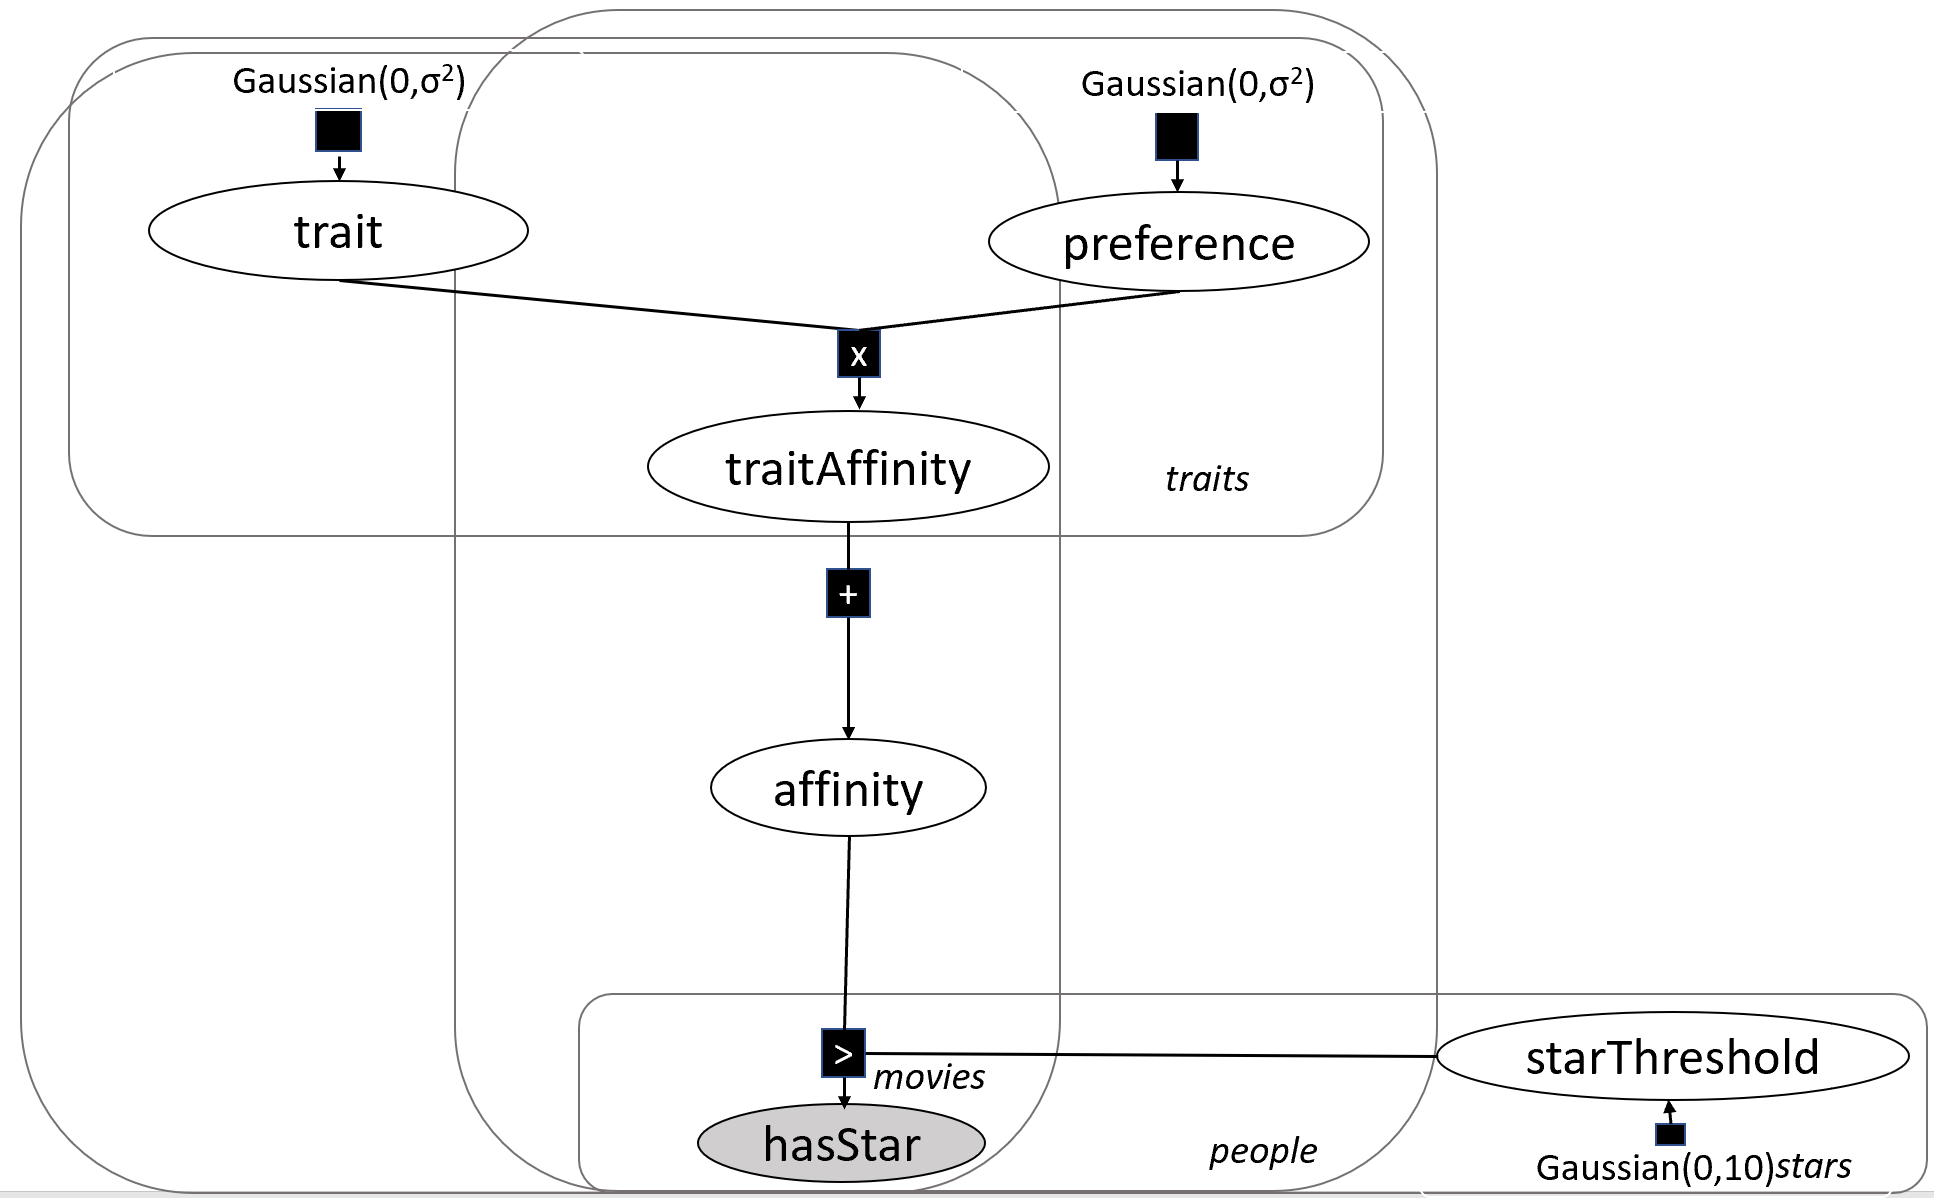

### Generative Story

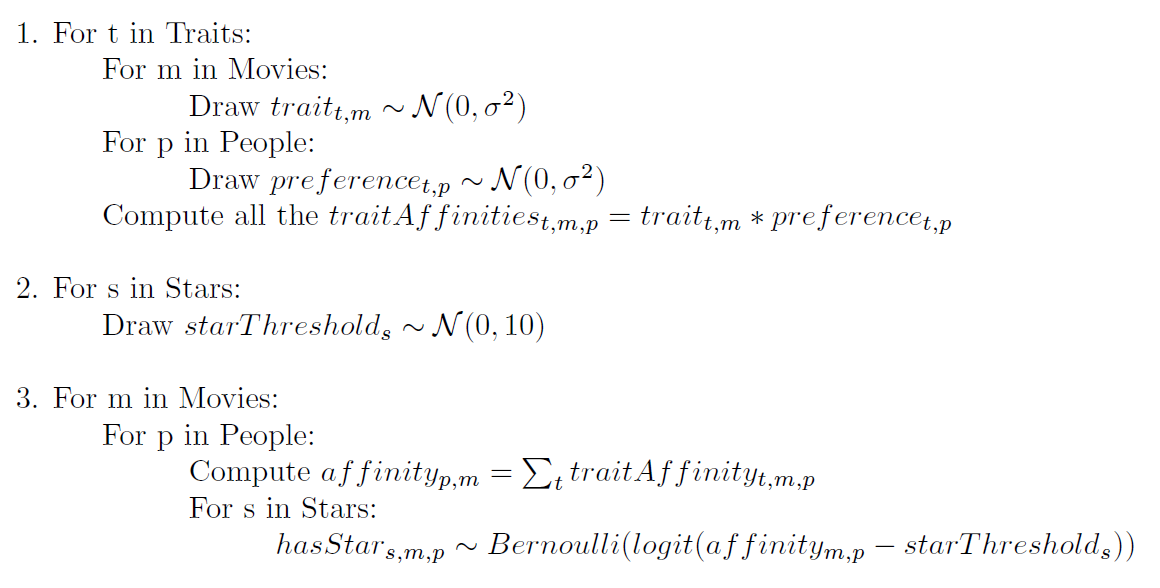

### Training the recommender

For each person, we will use 70\% of the ratings to train on and leave 30\% to use for validation.
We also removed ratings from the test set for any movies that do not appear anywhere in the training set.

When training the model, we infer the trait values for each movie and the preference values for each person.

In order to speed things up, we only took the ratings of the first 75 users, otherwise the model was way to big to handle for our computers.

# Preprocessing

In [3]:
df = pd.read_csv('data3.csv')

In [4]:
df = df.loc[:,['User_Id','Rating','Movie_Id','Date']]

In [16]:
# We spotted LOTR movies with IDs 10313 and 10352. In order to have a nice plot we want to include people
# that rated those two movies and take only the 75 first so that we don't have too much data. Our model is too
# heavy for our computers to handle otherwise

selected_users = df[(df['Movie_Id'] ==10313)]['User_Id'].unique() 
selected_users = np.append(selected_users,df[(df['Movie_Id'] ==10352)]['User_Id'].unique())
df_selected = df[df['User_Id'].isin(selected_users[:75])]

In [17]:
df_selected

,User_Id,Rating,Date,Movie_Id
7,2096652,3.0,2004-05-31,9211
2629,2370740,5.0,2003-08-29,9217
2643,838130,4.0,2003-06-12,9217
2684,1977128,1.0,2002-01-11,9217
2694,46036,4.0,2003-10-04,9217
2738,1863499,3.0,2003-11-07,9217
2760,2096652,5.0,2005-11-09,9217
2791,602149,2.0,2004-01-16,9217
2840,1705134,2.0,2004-04-29,9217
2862,2063030,3.0,2005-06-21,9217


In [18]:
# Building the test and train datasets.
# We need to have at least one movie per user in the train set and same for the movies.
# We need at least one rating in the training set.

train_perc = 0.7
df_train = pd.DataFrame(columns = df.columns)
df_test = pd.DataFrame(columns = df.columns)

for user in df_selected['User_Id'].unique():# NOT Optimal, look for stratified test_split
    M=len(df[df['User_Id'] == user])
    
    split_point = int(train_perc*M+1)
    df_user = df_selected[df_selected['User_Id'] == user].reset_index()
    if not (df_user.iloc[:split_point,:].empty):
        df_train=df_train.append(df_user[['User_Id','Rating','Movie_Id','Date']].iloc[:split_point,:],ignore_index=True)
    
    if not (df_user.iloc[split_point:M,:].empty):
        df_test=df_test.append(df_user[['User_Id','Rating','Movie_Id','Date']].iloc[split_point:M,:],ignore_index=True)

/home/cernewein/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [19]:
df_test = df_test[df_test['Movie_Id'].isin(df_train['Movie_Id'].unique())] 
# In the test set we cannot have movies that haven't been present in the training set

In [20]:
df_train.to_csv('train.csv')
df_test.to_csv('test.csv') # Saving files

In [4]:
df_train = pd.read_csv('train.csv')

In [5]:
# Transforming data into matrix with rows being persons and columns movies
# Training set containing the rating dates

dates_train = df_train.loc[:,['User_Id','Movie_Id','Date']]
dates_train.loc[:,'Date'] = pd.DatetimeIndex(dates_train['Date']).year

# Training set containing the ratings
df_train = df_train.loc[:,['User_Id','Rating','Movie_Id']]
df_train.index = pd.MultiIndex.from_frame(df_train[['User_Id','Movie_Id']]) 
df_train = df_train['Rating'].unstack(level=-1).fillna(0)

In [6]:
### Non optimised method
# We are transforming the integer ratings into binarized values:
# A rating of 2 will have values 1,0,0,0 (as the minimum rating is 1)
# While a rating of 4 will have 1,1,1,0
# Missing ratings will have -1 everywhere and will be discarded in the STAN model, and infered

P = len(df_train.index) # Number of persons (users)
M = len(df_train.columns) # Number of movies
transformed_score_train=np.zeros((len(df_train.index),len(df_train.columns),4))
for user in range(P):
    for movie in range(M):
        if df_train.values[user,movie] == 0:
            transformed_score_train[user,movie,:] = [-1]*4 # We will infer the missing ratings
        else:
            transformed_score_train[user,movie,:] = int(df_train.values[user,movie]-1)*[1]+(5-int(df_train.values[user,movie]))*[0]
        

In [23]:
transformed_score_train

array([[[-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        ...,
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.]],

       [[-1., -1., -1., -1.],
        [ 1.,  1.,  1.,  0.],
        [-1., -1., -1., -1.],
        ...,
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.]],

       [[-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        ...,
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.]],

       ...,

       [[-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        ...,
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.]],

       [[-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        ...,
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.]],

       [[-1.

# STAN Model

In [33]:
movie_rating_STAN="""
data {
    int<lower=0> T; // number of traits
    int<lower=0> M; // number of movies
    int<lower=0> P; // number of persons
    real<lower=0> sigma; // Variance for our preference and trait priors
    int<lower=-1,upper=1> hasStar[P,M,4];   // observed ratings dummy for rating
}
parameters {
    matrix<lower=-2,upper=2>[T,M] trait;          // Movie traits. We are using 2 traits for now
    matrix<lower=-2,upper=2>[T,P] preference; // Person preferences. 2 different types of preferences
    vector<lower=-10,upper=10>[4] starThreshold; // Thresholds for the different star ratings. 
    //If the person rates the movie 4 stars and above, then we need 2 and 3 stars and above to be equal to 1 also
}

transformed parameters{
    real<lower=-4,upper=4> traitAff[P,M,T]; // How much the person likes the trait value of a movie
    matrix<lower=-20,upper=20>[P,M] affinity; // How much the person likes a movie


    
    for (m in 1:M){
        for (p in 1:P){
            for (t in 1:T){
                traitAff[p,m,t] = trait[t,m]*preference[t,p];// Computing all trait affinities
                }
            }
        }

    for (m in 1:M){
            for (p in 1:P){
                affinity[p,m] = sum(traitAff[p,m]);
                }
        }
}

model {

    trait[1,1]~normal(1,0.01); // Initializing trait for first two movies values for symetry breaking
    trait[2,1]~normal(0,0.01);
    trait[1,2]~normal(0,0.01);
    trait[2,2]~normal(1,0.01);
    
    for (t in 1:T){
        for (m in 3:M){
            trait[t,m] ~ normal(0,sigma); // Trait prior
        }
        for (p in 1:P){
        preference[t,p] ~ normal(0, sigma); // Preference prior
        }

    }
    for (s in 1:4){
        starThreshold[s] ~ normal(0, 10); // StarThreshold prior
    }
    for (m in 1:M){
            for (p in 1:P){// If person didn't rate movie, skip it
                if (hasStar[p,m,1]!=-1){ // If we don't have a rating for the person, skip it
                    for (s in 1:4){
                    hasStar[p,m,s]~bernoulli_logit(affinity[p,m]-starThreshold[s]);
                        }
                    }
                }
                
        }
}
generated quantities {
// Nothing for now
}
"""

In [11]:
T=2
sigma=1/(T**0.5) # In order to have a total variance equal to 1

In [12]:
data = {'T':T,
        'M':M,
       'P':P,
       'hasStar':transformed_score_train.astype(int),
       'sigma':sigma}

In [13]:
# compile model
# Avoid recompiling the model everytime
import pickle
from hashlib import md5

def StanModel_cache(model_code, model_name=None, **kwargs):
    """Use just as you would `stan`"""
    code_hash = md5(model_code.encode('ascii')).hexdigest()
    if model_name is None:
        cache_fn = 'cached-model-{}.pkl'.format(code_hash)
    else:
        cache_fn = 'cached-{}-{}.pkl'.format(model_name, code_hash)
    try:
        sm = pickle.load(open(cache_fn, 'rb'))
    except:
        sm = pystan.StanModel(model_code=model_code)
        with open(cache_fn, 'wb') as f:
            pickle.dump(sm, f)
    else:
        print("Using cached StanModel")
    return sm



In [ ]:
sm = StanModel_cache(model_code=movie_rating_STAN, model_name="MovieRating") 
# Avoiding recompilation every single time

In [14]:
fit = sm.vb(data=data, iter=10000)

The ouput we get from the fitted model is in a dictionnary format. We had to manually save everything into a csv file and work on it in excel in order to separate the different infered variables.

We created different files for the movie traits, the persons preferences etc..

In [15]:
fit.keys() # Output from the stan model, which is in a big dict and thus a bit hard to handle in python

odict_keys(['args', 'inits', 'sampler_params', 'sampler_param_names', 'mean_pars', 'mean_par_names'])

In [16]:
df_results = pd.DataFrame.from_dict(dict((k, fit[k]) for k in ('mean_pars','mean_par_names')))

In [17]:
df_results.to_csv('results.csv') 
# We will have to do some manual transformation in excel as the df_results isn't in a nice format

In [18]:
pd.DataFrame(df_train.columns).to_csv('ModelIdVsRealID.csv') # For correspondance between the two Ids

In [19]:
traits = pd.read_excel('MovieTraits.xlsx') 
# Excel file with infered movie traits, each movie has two traits

In [20]:
traits

,Movie ID,Movie Name,Trait,Value
0,9211,Blue Juice,1,1.043127
1,9211,Blue Juice,2,-0.033536
2,9217,Cheech & Chong's Nice Dreams,1,0.036775
3,9217,Cheech & Chong's Nice Dreams,2,0.977377
4,9218,Lady Jane,1,-0.136266
5,9218,Lady Jane,2,-0.086264
6,9222,Dear God,1,0.030442
7,9222,Dear God,2,-0.321421
8,9223,Foxy Brown,1,-0.314734
9,9223,Foxy Brown,2,-0.075952


## Model Evaluation

Below is represented a plot of the different movies and the value of their two traits. Here, we've qualitatively evaluated the accuracy of the model in terms of traits. To do so, we've selected a pairs of movies. In each pair are two movies known as really close in terms of traits and characteristics. To ensure that indeed we can assume they are close, we've chosen in each pair only movies of a same serie. Of course, these movies have many characteristics which can change from one movie to another even in a same serie. Yet, it still appeared interesting to see the results...


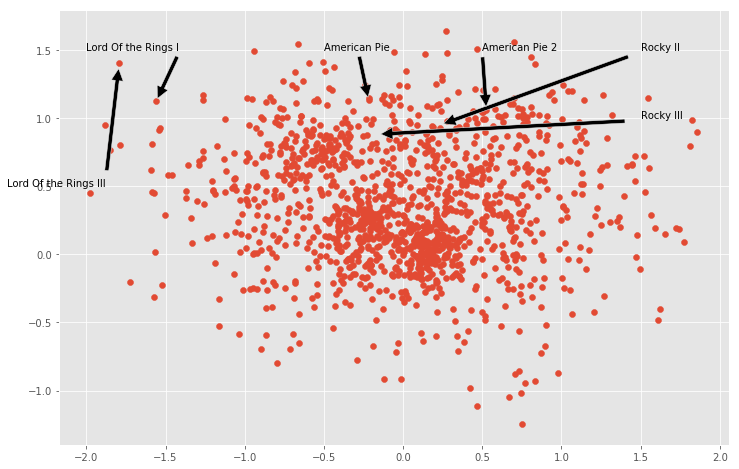

In [36]:
first_trait = traits[traits['Trait']==1]['Value'].values
second_trait = traits[traits['Trait']==2]['Value'].values
fig= plt.figure()
ax = fig.add_subplot(111)

# First lord of the rings movie
LOTR1x = traits[(traits['Trait']==1) & (traits['Movie Name']== "Lord of the Rings: The Fellowship of the Ring: Bonus Material")]['Value'].values[0]
LOTR1y =traits[(traits['Trait']==2) & (traits['Movie Name']== "Lord of the Rings: The Fellowship of the Ring: Bonus Material")]['Value'].values[0]
ax.annotate('Lord Of the Rings I', xy=(LOTR1x,LOTR1y), xytext=(-2, 1.5),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
# Third Lord of the Rings movie
LOTR2x = traits[(traits['Trait']==1) & (traits['Movie Name']== "Lord of the Rings: The Return of the King: Bonus Material")]['Value'].values[0]
LOTR2y =traits[(traits['Trait']==2) & (traits['Movie Name']== "Lord of the Rings: The Return of the King: Bonus Material")]['Value'].values[0]
ax.annotate('Lord Of the Rings III', xy=(LOTR2x,LOTR2y), xytext=(-2.5, 0.5),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )

# Rocky II
ROCKY2x = traits[(traits['Trait']==1) & (traits['Movie Name']== "Rocky II")]['Value'].values[0]
ROCKY2y =traits[(traits['Trait']==2) & (traits['Movie Name']== "Rocky II")]['Value'].values[0]
ax.annotate('Rocky II', xy=(ROCKY2x,ROCKY2y), xytext=(1.5, 1.5),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )

# Rocky III
ROCKY3x = traits[(traits['Trait']==1) & (traits['Movie Name']== "Rocky III")]['Value'].values[0]
ROCKY3y =traits[(traits['Trait']==2) & (traits['Movie Name']== "Rocky III")]['Value'].values[0]
ax.annotate('Rocky III', xy=(ROCKY3x,ROCKY3y), xytext=(1.5, 1),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )

# American Pie



APx = traits[(traits['Trait']==1) & (traits['Movie Name']== "American Pie")]['Value'].values[0]
APy =traits[(traits['Trait']==2) & (traits['Movie Name']== "American Pie")]['Value'].values[0]
ax.annotate('American Pie ', xy=(APx,APy), xytext=(-0.5, 1.5),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )

AP2x = traits[(traits['Trait']==1) & (traits['Movie Name']== "American Pie 2")]['Value'].values[0]
AP2y =traits[(traits['Trait']==2) & (traits['Movie Name']== "American Pie 2")]['Value'].values[0]
ax.annotate('American Pie 2', xy=(AP2x,AP2y), xytext=(0.5, 1.5),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.scatter(first_trait,second_trait)

The sample results appears as quite satisfactory as movies from a same serie are plotted close to each other. This means that the two traits which summarize the different characteristics of the movie appear are almost the same in each pair, and thus our model succeeded guessing that these movies were very close in terms of traits, having at the beginning absolutely no information concerning this from the dataset!

In [38]:
pd.DataFrame(df_train.index).to_csv('UserIds.csv')

In [2]:
# Just as we did for the movie traits, we had to transform the results into a nice format for the person's
# affinities as well. Here we are reading this excel file.
affinities = pd.read_excel('Affinities.xlsx')

In [3]:
df_test = pd.read_csv('df_test.csv')

Another interesting thing to see to verify that our model went in the right direction is to check the star thresholds. They are given below, and also appears correct and do not highlights mistakes from our model, as the value of starThreshold(i) is indeed always inferior to the value of starThreshold(i + 1)
This again reassures us on the results, but is of course not enough to say that our predictions are of very good quality. To check that, we've used other metrics later in the notebook...

In [4]:
# The values for the thresholds are the infered starThreshold values
# Those were directly read from the output csv file
affinities['has2Stars'] = (affinities['Value'] >= -3.872290555)*1
affinities['has3Stars'] = (affinities['Value'] >= -2.08430827)*1
affinities['has4Stars'] = (affinities['Value'] >= 0.1344112)*1
affinities['has5Stars'] = (affinities['Value'] >= 2.240692476)*1

# Using these affinity values we can directly see how many stars a user would have given a certain user to a certain movie
# Those affinity values are inferred and we have them for each user/movie pair, meaning also thoe we had in the test set


In [5]:
affinities

,Value,Movie,Original Movie Id,Person,Original Person Id,has2Stars,has3Stars,has4Stars,has5Stars
0,-1.675339,1,9211,1,1810,1,1,0,0
1,-2.077766,1,9211,2,46036,1,1,0,0
2,-1.299843,1,9211,3,115498,1,1,0,0
3,-1.100683,1,9211,4,139297,1,1,0,0
4,-0.907082,1,9211,5,150553,1,1,0,0
5,-1.844904,1,9211,6,221091,1,1,0,0
6,-1.353796,1,9211,7,232270,1,1,0,0
7,-1.760825,1,9211,8,267690,1,1,0,0
8,-1.852864,1,9211,9,318301,1,1,0,0
9,-1.945637,1,9211,10,411414,1,1,0,0


In [6]:
affinities['Stars'] = affinities.iloc[:,5:].sum(axis=1)+1

In [7]:
affinities

,Value,Movie,Original Movie Id,Person,Original Person Id,has2Stars,has3Stars,has4Stars,has5Stars,Stars
0,-1.675339,1,9211,1,1810,1,1,0,0,3
1,-2.077766,1,9211,2,46036,1,1,0,0,3
2,-1.299843,1,9211,3,115498,1,1,0,0,3
3,-1.100683,1,9211,4,139297,1,1,0,0,3
4,-0.907082,1,9211,5,150553,1,1,0,0,3
5,-1.844904,1,9211,6,221091,1,1,0,0,3
6,-1.353796,1,9211,7,232270,1,1,0,0,3
7,-1.760825,1,9211,8,267690,1,1,0,0,3
8,-1.852864,1,9211,9,318301,1,1,0,0,3
9,-1.945637,1,9211,10,411414,1,1,0,0,3


In [8]:
# Computing the predicted number of stars for the test set
df_test['Predicted'] = np.nan
for user in df_test['User_Id'].unique():
    for movie in df_test['Movie_Id'].unique():
        if not (df_test[(df_test['User_Id'] == user) & (df_test['Movie_Id'] == movie)].empty):
            df_test.loc[(df_test['User_Id'] == user) & (df_test['Movie_Id'] == movie),'Predicted'] = affinities[(affinities['Original Person Id'] == user)  & (affinities['Original Movie Id'] == movie)]['Stars'].values[0]

In [9]:
# We also add a baseline for comparision.
# 3 stars is taken as baseline as it is exactly the middle between 1 and 5
df_test['Baseline'] = 3.0

In [10]:
df_test

,Unnamed: 0,User_Id,Rating,Movie_Id,Predicted,Baseline
0,0,2096652,3.0,12243,4.0,3.0
1,1,2096652,4.0,12244,3.0,3.0
2,2,2096652,4.0,12255,4.0,3.0
3,3,2096652,4.0,12292,4.0,3.0
4,4,2096652,2.0,12299,4.0,3.0
5,5,2096652,3.0,12305,4.0,3.0
6,6,2096652,4.0,12317,4.0,3.0
7,8,2096652,5.0,12338,4.0,3.0
8,10,2096652,1.0,12355,4.0,3.0
9,85,2370740,5.0,12172,4.0,3.0


Let's try to evaluate our model's accuracy. To do so, and in order to differentiate big mistakes from little mistakes (indeed, forecasting 1 star instead of 5 is worse than forecasting 2 instead of 4 stars), we'll use the following error measure:

Error = |Predicted star rating - Ground truth star rating|

We'll compute this error for each prediction using the test set, and take the average on all these absolute errors of each prediction. The result is a metric called mean absolute error (MAE).
The result is given below. It is of less than 1 star in average, and can be considered as quite good! Our predictions also do better than a baseline of 3 stars predicted for each movie/user pair.

In [34]:
np.mean(np.abs(df_test['Rating'].values - df_test['Predicted'].values))

0.7210365853658537

In [19]:
np.mean(np.abs(df_test['Rating'].values - df_test['Baseline'].values))

0.8948170731707317

#### Another metric

Another way to measure the quality of the recommendations is to see what the added value of the recommender is. Ie if the movies we advice a person would really enjoy the recommendations we made for him. Usually recommender systems generate a list of proposed movies, we would thus like to reward correct predictions at the top of the list and vice-versa.

A metric for such a case is the Discounted Cumulative Gain. We will for example for 5 movies sum the ratings the user gave them multiplied by some discount function $\frac{1}{log_{2}(position + 1)}$ decreasing the further it is down the list. In order to have comparable results across the users, we can normalize this sum by the maximum achievable DCG with those 5 movies. We want to be as close as possible to 1.

In our example the normalized DCG would be $8.83/9.64=0.857$

![](DCG_bad.PNG)
![](DCG_perfect.PNG)


In [11]:
users = df_test.groupby('User_Id')['Rating'].count()>=5
users = users[users]
df_test_5 = df_test[df_test['User_Id'].isin(users.index)].iloc[:,1:]

In [12]:
df_test_5

,User_Id,Rating,Movie_Id,Predicted,Baseline
0,2096652,3.0,12243,4.0,3.0
1,2096652,4.0,12244,3.0,3.0
2,2096652,4.0,12255,4.0,3.0
3,2096652,4.0,12292,4.0,3.0
4,2096652,2.0,12299,4.0,3.0
5,2096652,3.0,12305,4.0,3.0
6,2096652,4.0,12317,4.0,3.0
7,2096652,5.0,12338,4.0,3.0
8,2096652,1.0,12355,4.0,3.0
9,2370740,5.0,12172,4.0,3.0


In [13]:
NDCG = pd.DataFrame(columns=df_test_5.columns)
for user in users.index:
    temp = df_test_5[df_test_5['User_Id'] == user].reset_index()
    NDCG=NDCG.append(temp.iloc[:5,1:],ignore_index=True) # We only want 5 movies per user

In [14]:
NDCG = NDCG.sort_values(by=['User_Id','Predicted'],ascending=False) 
# We are sorting the movies for each user based on the predicted number of stars

In [15]:
position= np.array([1,2,3,4,5]*int((len(NDCG.index)/5)))

In [16]:
# We attribute a "rank" or position to each movie for each user.
# We have 5 movies per user
NDCG['predicted_position']=position

In [17]:
NDCG['score_predicted'] = NDCG['Rating'].values/np.log2(NDCG['predicted_position'].values+1) #Discount value

In [18]:
predicted_score = NDCG.groupby('User_Id').sum()['score_predicted'].mean() # The score for our predictions

In [19]:
NDCG = NDCG.sort_values(by=['User_Id','Rating'],ascending=False) 
# Sorting this time on real value for getting perfect score
position= np.array([1,2,3,4,5]*int((len(NDCG.index)/5)))
NDCG['optimal_position']=position
NDCG['score_optimal'] = NDCG['Rating'].values/np.log2(NDCG['optimal_position'].values+1)
optimal_score = NDCG.groupby('User_Id').sum()['score_optimal'].mean()

In [20]:
predicted_score/optimal_score

0.9533651855214366

The score appears to be surprisingly good. 
One could remark however that the predicted_score depends on the way the ordering is done. For instance, should someone have true ratings of 3 then 4 for two movies, and our predictions are 3 and 3, we would not get the same predicted score if pandas ranks the first movie first, or if it ranks the second movie first (here, pandas tends to allow better scores by ordering in a way which increase the predicted_score/optimal_score).
Also, one can see that some people gave for instance only 3. Thus, even if our prediction are completely different from 3, we'll anyway get a good score.

## Extending our model...

As we have the dates on which each rating have been submitted by a user, as well as the date when each movie was released, we thought that we could model with this data the fact that users rates differently a movie, whether it has just been released, or it is very old for instance. We thus tried to implement this idea in our model. To do so, we've computed the difference between the date of the rating and the date when the movie was released. This value can belong to 6 categories: inferior to 1 year, between 1 and 5 years, 5 and 10, 10 and 20, 20 and 50 and finally more than 50 years).
We categorized our data because we suspect a non linear relationship between the time difference and the affinity.

Unfortunately, we didn't manage to get results from STAN, due to technical mistakes we may have done and have failed to spot in time. 

The PGM representing our updated model is represented below.
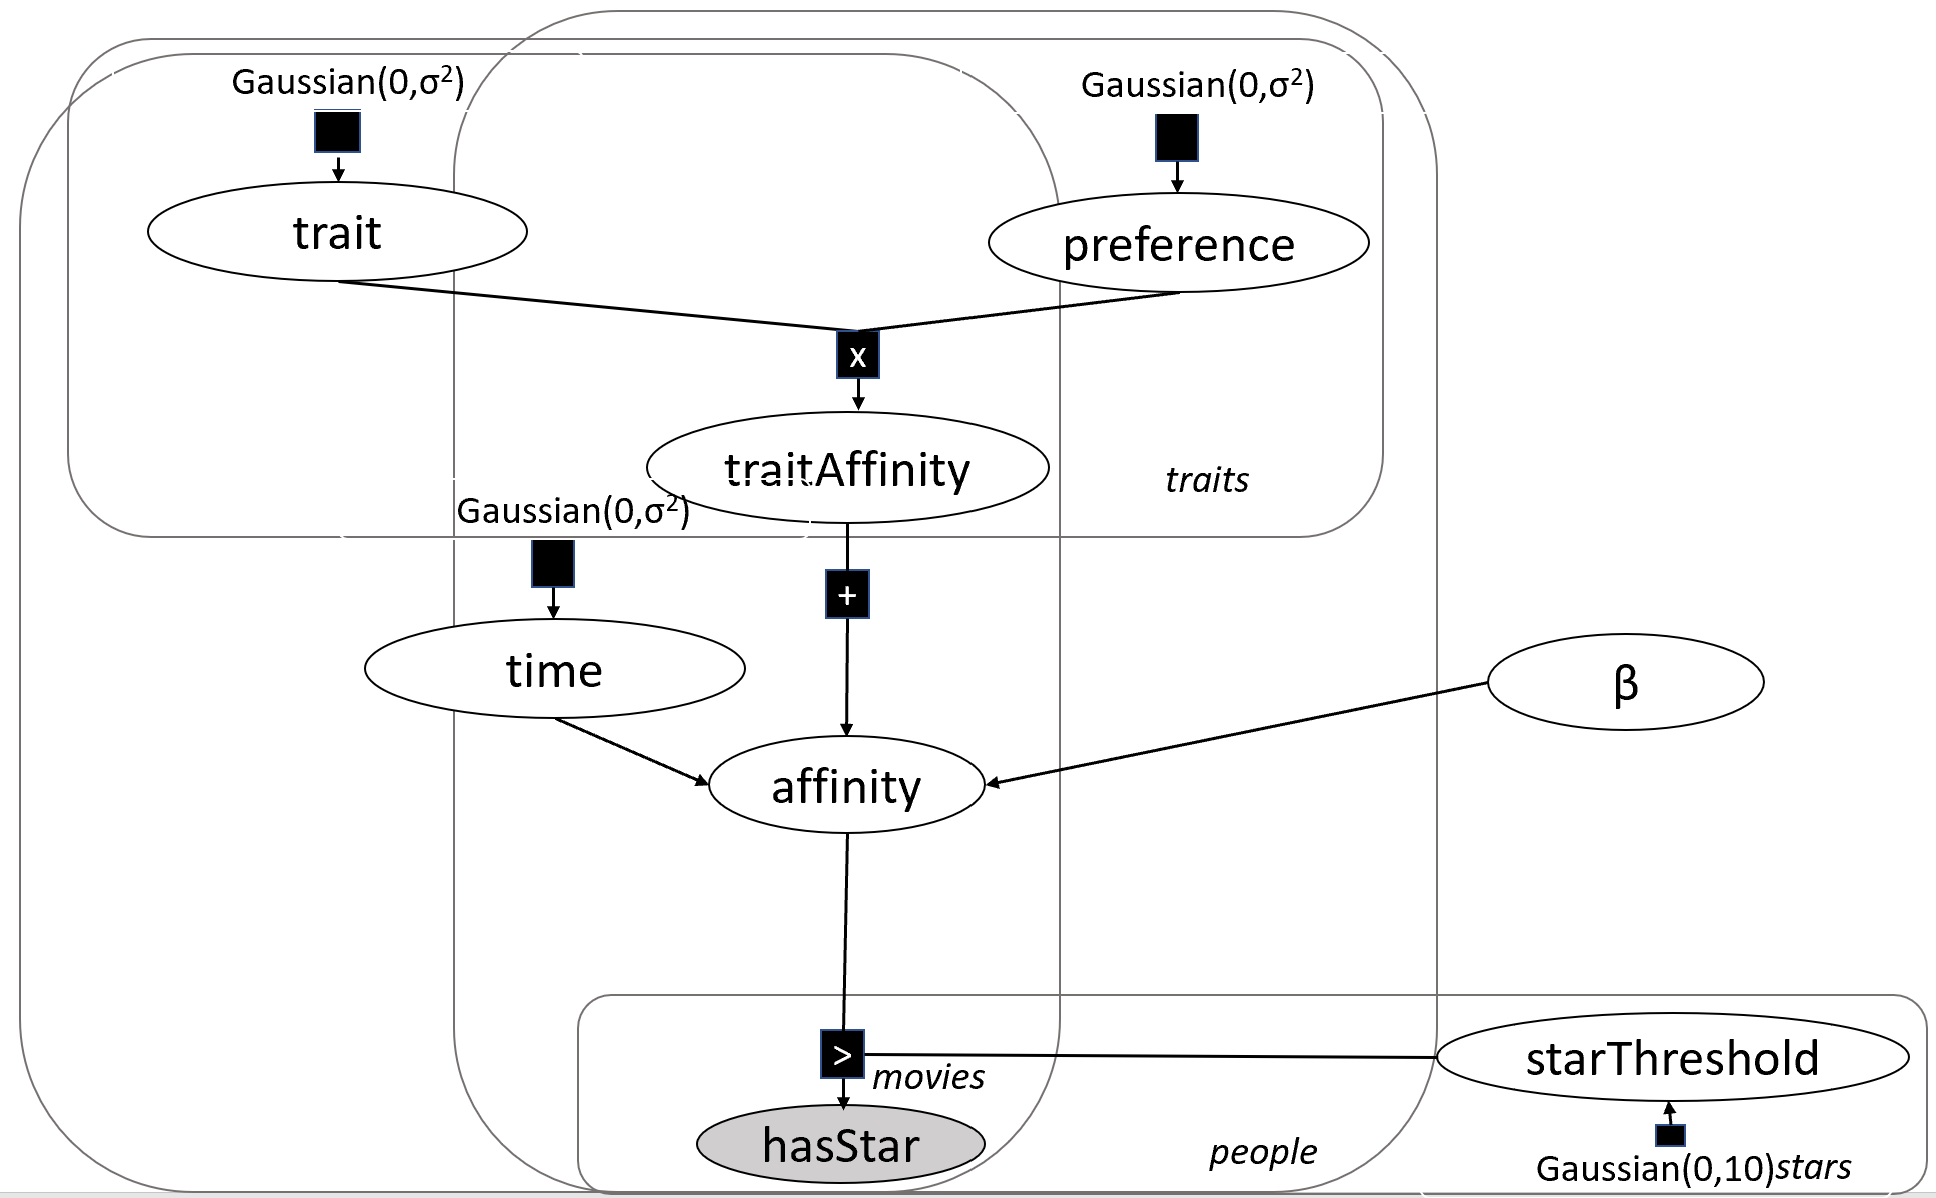

The generative story is given below. 
![](SecondModelGenerative.PNG)

Using a logit with a bernoulli distribution has the same effect as adding noise and then thresh-
olding, it is for allowing a less rough transition that could make the model intractable.  This was way
easier to implement in the code as there is a built-in
Bernoullilogit method in Stan.

In [7]:
dates_train.index = pd.MultiIndex.from_frame(dates_train[['User_Id','Movie_Id']]) 
# Transforming the dates dataframe into similar format as the ratings
dates_train = dates_train['Date'].unstack(level=-1).fillna(2019) #Filling missing values with the current year

In [8]:
### Non optimised method
### NOT Scalable
P = len(dates_train.index) # Number of persons (users)
M = len(dates_train.columns) # Number of movies
# Transforming the dates into a similar shaped matrix as for the ratings.
# Instead of having a binarized score, we have dummies for the categories
transformed_date_train=np.zeros((P,M,6))
for user in range(P):
    for movie in range(M):
        category = []
        diff = dates_train.values[user,movie] - df_title[df_title['Movie_Id'] == dates_train.columns[movie]]['Year'].values[0]
        category += [(diff<=1)*1]
        category += [((diff>1) and (diff<=5))*1]
        category += [((diff>5) and (diff<=10))*1]
        category += [((diff>10) and (diff<=20))*1]
        category += [((diff>20) and (diff<=50))*1]
        category += [(diff>50)*1]
        transformed_date_train[user,movie,:] = category
        

In [24]:
movie_rating_temporal_STAN="""
data {
    int<lower=0> T; // number of traits
    int<lower=0> M; // number of movies
    int<lower=0> P; // number of persons
    real<lower=0> sigma; // variance for priors
    int<lower=-1,upper=1> hasStar[P,M,4];   // observed ratings dummy for rating
    int<lower=0,upper=1> timedelta[P,M,6];   // number of years between rating and movie release date. We have 6 categories in total
}
parameters {
    matrix<lower=-2,upper=2>[T,M] trait;          // Movie traits. We are using 2 traits for now
    matrix<lower=-2,upper=2>[T,P] preference; // Person preferences. 2 different types of preferences
    vector<lower=-10,upper=10>[4] starThreshold; // Thresholds for the different star ratings. If the person rates the movie 4 stars and above, then we need 2 and 3 stars and above to be equel to 1 also
    vector<lower=-5,upper=5>[6] Regression; // Regression coefficients for adding temporal data
    matrix<lower=-10,upper=10>[P,M] noisyTemporalAffinity; // Temporal aspect
}

transformed parameters{
    real<lower=-4,upper=4> traitAff[P,M,T]; // How much the person likes the trait value of a movie
    matrix<lower=-25,upper=25>[P,M] affinity; // How much the person likes a movie
    matrix<lower=-5,upper=5>[P,M] temporalAffinity; // Temporal aspect

    
    for (m in 1:M){
        for (p in 1:P){
            for (t in 1:T){
                traitAff[p,m,t] = trait[t,m]*preference[t,p];// Computing all trait affinities
                }
            }
        }

    for (m in 1:M){
            for (p in 1:P){
                for (b in 1:6){
                    temporalAffinity[p,m] += Regression[b]*timedelta[p,m,b];
                }
                affinity[p,m] = sum(traitAff[p,m]) + noisyTemporalAffinity[p,m];
                }
        }
}

model {

    trait[1,1]~normal(1,0.01); // Initializing trait for first two movies values for symetry breaking
    trait[2,1]~normal(0,0.01);
    trait[1,2]~normal(0,0.01);
    trait[2,2]~normal(1,0.01);
    
    for (b in 1:6){
        Regression[b] ~ normal(0,2);
    }

    
    for (t in 1:T){
        for (m in 3:M){
            trait[t,m] ~ normal(0,sigma); // Trait prior
        }
        for (p in 1:P){
        preference[t,p] ~ normal(0, sigma); // Preference prior
        }

    }
    for (s in 1:4){
        starThreshold[s] ~ normal(0, 10); // StarThreshold prior
    }
    for (m in 1:M){
            for (p in 1:P){
            noisyTemporalAffinity[p,m] ~ normal(temporalAffinity[p,m],5);
            // If person didn't rate movie, skip it
                if (hasStar[p,m,1]!=-1){ // If we don't have a rating for the person, skip it
                    for (s in 1:4){
                    hasStar[p,m,s]~bernoulli_logit(affinity[p,m]-starThreshold[s]);
                        }
                    }
                }
                
        }
}
generated quantities {
// Nothing for now
}
"""

In [10]:
T=2
sigma=1/(T**0.5) # In order to have a total variance equal to 1

In [11]:
data = {'T':T,
        'M':M,
       'P':P,
       'hasStar':transformed_score_train.astype(int),
        'timedelta':transformed_date_train.astype(int),
       'sigma':sigma}

In [25]:
sm = StanModel_cache(model_code=movie_rating_temporal_STAN, model_name="MovieRatingDate")


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3152cf9201228f3b07d02a2b337dcc87 NOW.
/home/cernewein/anaconda3/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmpgu5eajuk/stanfit4anon_model_3152cf9201228f3b07d02a2b337dcc87_5658856586885636099.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [26]:
fit = sm.vb(data=data, iter=10000)

RuntimeError: Initialization failed.